In [1]:
import os

import pytorch_lightning as pl

import matplotlib as mp
%matplotlib inline
import matplotlib.pyplot as plt

from clip_graph import lit as lg
from clip_graph import GraphTextsDataModule

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-ziud9k5c because the default path (/mas/u/wbrannon/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
os.chdir(os.path.expanduser('~/github/clip-graph'))

In [3]:
seed = 2969591811

In [4]:
pl.seed_everything(seed, workers=True)

Global seed set to 2969591811


2969591811

# Load data

In [5]:
dm = GraphTextsDataModule(
    data_dir = 'data',
    mlm = False,
    batch_size = 64,
    num_workers = -1,
    pin_memory = True,

    # should match what was used for mpnet pretraining and our pretraining
    tokenizer = 'sentence-transformers/all-mpnet-base-v2',
)

dm.prepare_data()
dm.setup()

# Load models

In [6]:
trainable = lg.LitClipGraph(
        embed_dim = 768,
        dropout = 0.0,
        tau_init = 3.07,

        gnn_ckpt_path = 'lightning_logs/version_628/checkpoints/epoch=148-step=149.ckpt',
        gnn_ckpt_dropout = 0,
    
        lm_ckpt_path = 'lightning_logs/version_557/checkpoints/epoch=2-step=197361.ckpt',
        lm_pooling_mode = 'mean',
        lm_normalize = True,

        lr = 1.0e-4,
        weight_decay = 0,
        eps = 1.0e-6,
        betas = (0.9, 0.999),
)

Some weights of MPNetForMaskedLM were not initialized from the model checkpoint at sentence-transformers/all-mpnet-base-v2 and are newly initialized: ['lm_head.decoder.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
train_args = {
    'gpus': [1],
    'strategy': 'dp',
    
    'logger': False,
    'enable_checkpointing': False,

    'auto_lr_find': True,
}

trainer = pl.Trainer(**train_args)

/u/wbrannon/miniconda3/envs/dl/lib/python3.9/site-packages/pytorch_lightning/loops/utilities.py:91: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


# Tune LR

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint path at /u/wbrannon/github/clip-graph/.lr_find_5d860ace-53b1-455e-bdc7-1b91bdccbda3.ckpt
Learning rate set to 0.0199526231496888


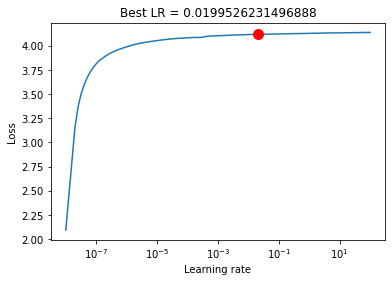

In [8]:
finder = trainer.tune(
    trainable,
    dm.train_dataloader(),
    dm.val_dataloader(),
    lr_find_kwargs={'max_lr': 100}
)['lr_find']

lr = finder.suggestion()
fig = finder.plot(suggest=True)
plt.title('Best LR = ' + str(lr))
plt.show()